In [1]:
from dwcal import delay_weighted_cal as dwcal
import numpy as np
import pyuvdata
from pyuvdata import utils
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Get data
data, model = dwcal.get_test_data(
    model_path="dwcal/data/model.uvfits",
    data_path="dwcal/data/data.uvfits",
    use_autos=False,
)

Loading model from dwcal/data/model.uvfits
Loading data from dwcal/data/data.uvfits


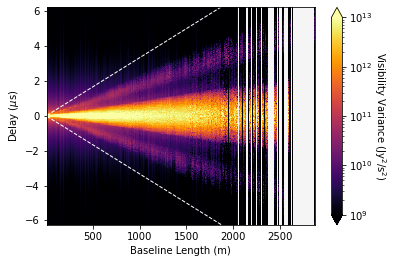

In [3]:
# Plot visibility error

# Difference visibilities
data.filename = [""]
model.filename = [""]
diff_vis = data.diff_vis(model, inplace=False)

# FFT across frequency
delay_array = np.fft.fftfreq(diff_vis.Nfreqs, d=diff_vis.channel_width)
delay_array = np.fft.fftshift(delay_array)
fft_abs = np.abs(np.fft.fftshift(np.fft.fft(diff_vis.data_array, axis=2), axes=2))
fft_abs *= diff_vis.channel_width

# Average in baseline length bins
nbins = 300
bl_lengths = np.sqrt(np.sum(diff_vis.uvw_array**2.0, axis=1))
bl_bin_edges = np.linspace(np.min(bl_lengths), np.max(bl_lengths), num=nbins + 1)
binned_variance = np.full([nbins, diff_vis.Nfreqs], np.nan, dtype="float")
for bin_ind in range(nbins):
    bl_inds = np.where(
        (bl_lengths > bl_bin_edges[bin_ind])
        & (bl_lengths <= bl_bin_edges[bin_ind + 1])
    )[0]
    if len(bl_inds) > 0:
        binned_variance[bin_ind, :] = np.mean(
            fft_abs[bl_inds, 0, :, 0] ** 2.0, axis=0
        )

# Plot
use_cmap = matplotlib.cm.get_cmap("inferno").copy()
use_cmap.set_bad(color="whitesmoke")
vmin = 1e9
vmax = 1e13
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
plt.imshow(
    binned_variance.T,
    origin="lower",
    interpolation="none",
    cmap=use_cmap,
    norm=norm,
    extent=[
        np.min(bl_bin_edges),
        np.max(bl_bin_edges),
        np.min(delay_array) * 1e6,
        np.max(delay_array) * 1e6,
    ],
    aspect="auto",
)

# Add horizon lines
plt.plot(
    [np.min(bl_bin_edges), np.max(bl_bin_edges)],
    [
        np.min(bl_bin_edges) / 3e8 * 1e6,
        np.max(bl_bin_edges) / 3e8 * 1e6,
    ],
    "--",
    color="white",
    linewidth=1.0,
)
plt.plot(
    [np.min(bl_bin_edges), np.max(bl_bin_edges)],
    [
        -np.min(bl_bin_edges) / 3e8 * 1e6,
        -np.max(bl_bin_edges) / 3e8 * 1e6,
    ],
    "--",
    color="white",
    linewidth=1.0,
)

cbar = plt.colorbar(extend="both")
cbar.ax.set_ylabel(
    "Visibility Variance (Jy$^{2}$/s$^2$)", rotation=270, labelpad=15
)
plt.xlabel("Baseline Length (m)")
plt.ylim([np.min(delay_array) * 1e6, np.max(delay_array) * 1e6])
plt.ylabel("Delay ($\mu$s)")
plt.show()

In [4]:
# Create randomized gains
random_gains_stddev = 0.01
random_gains = np.random.normal(
    1.0,
    random_gains_stddev,
    size=(data.Nants_data, data.Nfreqs),
) + 1.0j * np.random.normal(
    0.0,
    random_gains_stddev,
    size=(data.Nants_data, data.Nfreqs),
)

# Ensure that the phase of the gains is mean-zero for each frequency
avg_angle = np.arctan2(
    np.mean(np.sin(np.angle(random_gains)), axis=0),
    np.mean(np.cos(np.angle(random_gains)), axis=0),
)
random_gains *= np.cos(avg_angle) - 1j * np.sin(avg_angle)

# Create UVCal object
antenna_list = np.unique([data.ant_1_array, data.ant_2_array])
random_gains_cal = dwcal.initialize_cal(data, antenna_list, gains=random_gains)
random_gains_cal.gain_convention = "divide"  # Apply initial calibration as division

# Apply gains to data
pyuvdata.utils.uvcalibrate(data, random_gains_cal, inplace=True, time_check=False)

UVData object does not have `x_orientation` specified but UVCal does. Matching based on `x` and `y` only 


In [5]:
cal_diagonal = dwcal.calibration_optimization(
    data,
    model,
    weight_mat_option="diagonal",
)

weight_mat_option = 'diagonal': Weighting matrix is the identity
Time generating covariance matrix: 0.01777968406677246 minutes
Cost func. value: 1675868.110832145
Cost func. value: 750603.8884955561
Cost func. value: 724855.1852314875
Cost func. value: 721245.765240852
Cost func. value: 720602.8867441552
Cost func. value: 720477.9347931704
Cost func. value: 720452.4969631361
Cost func. value: 720447.0949365087
Cost func. value: 720445.9067450764
Cost func. value: 720445.6360677113
Cost func. value: 720445.5724985496
Cost func. value: 720445.5517069537
Cost func. value: 720445.5106515085
Cost func. value: 720445.365305754
Cost func. value: 720445.1150884299
Cost func. value: 720445.114919349
Cost func. value: 720445.1145787599
Cost func. value: 720445.1132354734
Cost func. value: 720445.1081675
Cost func. value: 720445.0964804853
Cost func. value: 720445.0843529123
Cost func. value: 720445.084350075
Optimization terminated successfully.
         Current function value: 720445.084350
  

In [6]:
cal_dwcal = dwcal.calibration_optimization(
    data,
    model,
    weight_mat_option="exponential window fit",
)

weight_mat_option = 'exponential window fit': Generating wedge excluding weighting matrix with an exponential window fit
Time generating covariance matrix: 2.3167415539423626 minutes
Cost func. value: 963612.0051847377
Cost func. value: 57157.487465385086
Cost func. value: 22516.1286671505
Cost func. value: 8066.750146019192
Cost func. value: 4178.099563308932
Cost func. value: 3061.186894850372
Cost func. value: 2753.2040352290073
Cost func. value: 2738.0037789250023
Cost func. value: 2711.443094697037
Cost func. value: 2678.528530798048
Cost func. value: 2667.0529808711444
Cost func. value: 2666.21725930579
Cost func. value: 2665.9083932108147
Cost func. value: 2665.8688923858394
Cost func. value: 2665.812126303026
Cost func. value: 2665.7953835542858
Cost func. value: 2665.7947401987385
Cost func. value: 2665.7946390434895
Cost func. value: 2665.794561811709
Cost func. value: 2665.794531472411
Cost func. value: 2665.7945297180477
Cost func. value: 2665.794529070028
Cost func. value:

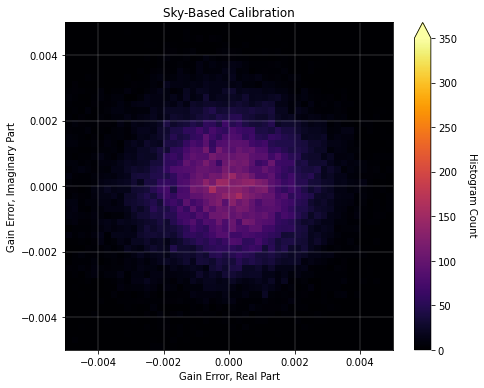

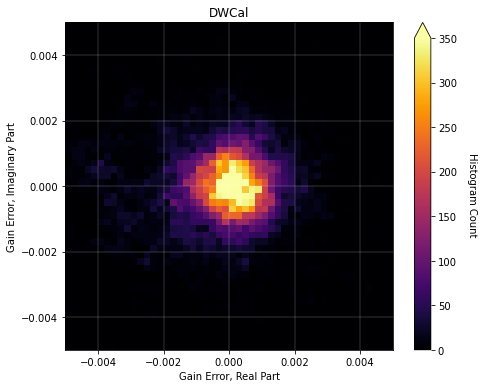

In [9]:
# Plot results

def histogram_plot_2d(
    plot_data,
    plot_range=0.005,
    nbins=50,
    colorbar_range=None,
    savepath=None,
    title="",
    axis_label="Gain Error",
    center_on_one=False,
):

    bins = np.linspace(-plot_range, plot_range, num=nbins + 1)
    hist, x_edges, y_edges = np.histogram2d(
        np.real(plot_data).flatten(),
        np.imag(plot_data).flatten(),
        bins=[bins, bins],
    )

    if colorbar_range is None:
        colorbar_range = [0, np.max(hist)]

    plt.figure(figsize=[7, 5.5])
    plt.imshow(
        hist.T,
        interpolation="none",
        origin="lower",
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        aspect="equal",
        cmap="inferno",
        vmin=colorbar_range[0],
        vmax=colorbar_range[1],
    )
    cbar = plt.colorbar(extend="max")
    cbar.ax.set_ylabel("Histogram Count", rotation=270, labelpad=20)
    plt.xlabel("{}, Real Part".format(axis_label))
    plt.ylabel("{}, Imaginary Part".format(axis_label))
    plt.title(title)
    plt.tight_layout()
    plt.grid(linewidth=0.2, color="white")
    plt.show()
    
def diff_gains(cal1, cal2):

    cal_diff = cal1.copy()
    if cal2 is None:
        cal_diff.gain_array -= 1.
    else:
        cal1_ant_names = cal1.antenna_names[cal1.ant_array]
        cal2_ant_names = cal2.antenna_names[cal2.ant_array]
        for ant_ind, ant_name in enumerate(cal1_ant_names):
            gains = cal1.gain_array[ant_ind, :, :, :, :]
            true_gains = cal2.gain_array[
                np.where(cal2_ant_names == ant_name)[0][0], :, :, :, :
            ]
            cal_diff.gain_array[ant_ind, :, :, :, :] = gains - true_gains

    return cal_diff

cal_diag_error = diff_gains(cal_diagonal, random_gains_cal)
histogram_plot_2d(
    cal_diag_error.gain_array.flatten(),
    colorbar_range=[0,350],
    title="Sky-Based Calibration",
)

cal_dwcal_error = diff_gains(cal_dwcal, random_gains_cal)
histogram_plot_2d(
    cal_dwcal_error.gain_array.flatten(),
    colorbar_range=[0,350],
    title="DWCal",
)